# Extracting Radio Link Attributes from GISs and OSM

In [1]:
# import packages
import os
import osmnx as ox
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# set seaborn properties
sns.set(font_scale=1.5, style="white")

# load raster packages
from shapely.geometry import Point, Polygon, LineString
import xarray as xr
import rioxarray as rxr
import rasterio as rio
import geopandas as gpd

import earthpy as et
import earthpy.plot as ep

In [1]:
pwd()

'/Users/sander/Desktop/lora-tools'

## 1. Define  Tools

In [2]:
# define raster summary function
def summary(raster):
    print("The crs is:", raster.rio.crs)
    print("The nodatavalue is:", raster.rio.nodata)
    #print('The min value is:', np.nanmin(raster))
    #print('The max value is:', np.nanmax(raster))
    print("The shape is:", raster.shape)
    print("The spatial resolution is:", raster.rio.resolution())
    print("Metadata:", raster.attrs)
    print("The number of bands is:", raster.rio.count)

In [3]:
# get mercator coordinates
def merc(lat, lon):
    r_major = 6378137.000
    x = r_major * np.radians(lon)
    scale = x / lon
    y = (180.0/np.pi) * np.log(np.tan((np.pi/4.0) + lat*(np.pi/180.0)/2.0)) * scale
    return x,y

### 1.1 (Optional) Get Antwerp boundary

In [4]:
# load road and waterway network
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    # load area
    place_name = 'Antwerp, Belgium'
    area = ox.geocode_to_gdf(place_name)
    
# set area crs to raster crs
crs = 'EPSG:31370'
area = area.to_crs(crs)
print(area.crs)

EPSG:31370


## 2. Get Link Dataset

In [5]:
file_name = '/Volumes/Transcend/lora/data/traffic/antwerp_rich_2000_clean.csv'
data = pd.read_csv(file_name)
df = pd.DataFrame(data)

#### Get Largest DSM raster

In [6]:
# load data
path = '/Volumes/Transcend/lora/data/antwerp-gis/dsm-1m-clipped.tif'
dsm = rxr.open_rasterio(path, masked=True)  # maks NaNs
dsm = dsm.squeeze()

In [29]:
dsm.rio.crs

CRS.from_epsg(31370)

In [32]:
from pyproj import Proj

p = Proj('EPSG:31370')

left, bot, right, top = dsm.rio.bounds()

e, s = p(left, bot, inverse=True)
w, n = p(right, top, inverse=True)

### 2.1. Visualize link data

In [9]:
# load bokeh
from bokeh.plotting import figure, show, output_file
from bokeh.tile_providers import get_provider, Vendors
from bokeh.io import output_notebook, curdoc, reset_output
from bokeh.palettes import Reds7
from bokeh.models import ColumnDataSource, GeoJSONDataSource, MultiLine, Rect

# make bokeh load in notebook
output_notebook()

Loading BokehJS ...

In [34]:
# plot links
#n, s, e, w =  51.288, 51.174, 4.55, 4.22

# small bbox coords (clipped-small)
ns, ss, es, ws =  51.248, 51.196, 4.452, 4.364


# get plot range
max_x, max_y = merc(n,e)
min_x, min_y = merc(s,w)

# get data
df_tx = df.groupby('packet_id').first()
df_gw = df.groupby('gateway_id').first()

# get successful links
temp = df[df['rssi'].notnull()].copy()

# get xs
x_tr = temp['x_tr'].values
x_gw = temp['x_gw'].values
xs = [np.array([x_tr[i], x_gw[i]]) for i in range(len(x_tr))]

# get ys
y_tr = temp['y_tr'].values
y_gw = temp['y_gw'].values
ys = [np.array([y_tr[i], y_gw[i]]) for i in range(len(y_tr))]


# define bbox plotting data
x = [merc(ss,ws)[0]]
y = [merc(ss,ws)[1]]
wi = [merc(ss,es)[0] - merc(ss,ws)[0]]
hi = [merc(ns,ws)[1] - merc(ss,ws)[1]]


# declare plot
plot = figure(x_range=(min_x, max_x), y_range=(min_y, max_y),
              x_axis_type="mercator", y_axis_type="mercator",
              title="Successfull links and gateways",
              plot_width=800, plot_height=520) 

# add background tile
plot.add_tile(get_provider(Vendors.CARTODBPOSITRON_RETINA))


# define rectangle
x = [(merc(n,e)[0] + merc(n,w)[0])/2]
y = [(merc(n,e)[1] + merc(s,e)[1])/2]
wi = [merc(s,e)[0] - merc(s,w)[0]]
hi = [merc(n,w)[1] - merc(s,w)[1]]


# data source
source_bx = ColumnDataSource(dict(x = x, y = y, w=wi, h=hi))
source_lk = ColumnDataSource(dict(xs = xs, ys = ys))
source_tx = ColumnDataSource(df_tx)
source_gw = ColumnDataSource(df_gw)

# bbox plot
plot.rect(source=source_bx, x='x', y='y', width='w', height='h',
          fill_alpha=0, line_color='mediumblue', line_width=1)

# packet origin circles
plot.circle(source=source_tx, x='x_tr', y='y_tr', line_color='mediumblue',
            fill_color='mediumblue', alpha=0.1, size=3)

# get lines
lines = MultiLine(xs="xs", ys="ys", line_color="magenta", line_width=0.5, line_alpha=0.1)
plot.add_glyph(source_lk, lines)


# GW circles
plot.circle(source=source_gw, x='x_gw', y='y_gw', line_color='black',
            fill_color='lightpink', alpha=1, size=8)





show(plot)

In [35]:
# make the link dataframe into geopandas

# zip the coordinates into a points
point_tr = [Point(xy) for xy in zip(df['lon_tr'], df['lat_tr'])]
point_gw = [Point(xy) for xy in zip(df['lon_gw'], df['lat_gw'])]

# zip points into linestrings
geometry = [LineString(xy) for xy in zip(point_tr, point_gw)]

# makge geopandas df
gdf = gpd.GeoDataFrame(df, geometry=geometry)


gdf = gdf.set_crs('epsg:4326')
gdf = gdf.to_crs("EPSG:31370")

In [36]:
# get gateway geo-df
gws = gpd.GeoDataFrame(df, geometry = point_gw)
gws = gws.groupby('gateway_id').first()

gws = gws.set_crs('epsg:4326')
gws = gws.to_crs("EPSG:31370")

In [37]:
# get bounding box geo-df
# declare bounding box - based on ever used GWs in Antwerp

#n, s, e, w =  51.27, 51.174, 4.502, 4.32 # larger bounds (clipped)
#n, s, e, w =  51.248, 51.196, 4.452, 4.364 # smaller bounds (clipped-small)

bbox = [w, s, e, n] # from bokeh plot (blue rect)

p1 = Point(bbox[0], bbox[3])
p2 = Point(bbox[2], bbox[3])
p3 = Point(bbox[2], bbox[1])
p4 = Point(bbox[0], bbox[1])

np1 = (p1.coords.xy[0][0], p1.coords.xy[1][0])
np2 = (p2.coords.xy[0][0], p2.coords.xy[1][0])
np3 = (p3.coords.xy[0][0], p3.coords.xy[1][0])
np4 = (p4.coords.xy[0][0], p4.coords.xy[1][0])

bb_polygon = Polygon([np1, np2, np3, np4])

bbox = gpd.GeoDataFrame(gpd.GeoSeries(bb_polygon), columns=['geometry'])

bbox = bbox.set_crs('epsg:4326')
bbox = bbox.to_crs("EPSG:31370")

In [38]:
# filter links with GW point in bbox
in_bbox = dict(gws['geometry'].within(bbox.iloc[0].geometry))

# filter gws
old = gdf.shape[0]
gdf.drop(gdf[~gdf['gateway_id'].map(in_bbox)].index, inplace=True)
new = gdf.shape[0]

print("Dropped %d out of %d rows." % (old-new, old))

Dropped 2743 out of 60207 rows.


In [39]:
# filer origins not in box (linestring)
in_bbox = gdf['geometry'].within(bbox.iloc[0].geometry)

# filter gws
old = gdf.shape[0]
gdf.drop(gdf[~in_bbox].index, inplace=True)
new = gdf.shape[0]

print("Dropped %d out of %d rows." % (old-new, old))

Dropped 0 out of 57464 rows.


In [40]:
# drop same ones in gws
old = gws.shape[0]
gws.drop(gws[~gws['geometry'].within(bbox.iloc[0].geometry)].index, inplace=True)
new = gws.shape[0]

print("Dropped %d out of %d gateways." % (old-new, old))

Dropped 3 out of 32 gateways.


In [41]:
# summarize remaining data
npackets = gdf['packet_id'].nunique()
ngateways = gdf['gateway_id'].nunique()
nrows = gdf.shape[0]

print("Remaining data are:")
print("\t Unique packets:  %d" % npackets)
print("\t Unique gateways: %d" % ngateways)
print("\t Total links:     %d" % nrows)

Remaining data are:
	 Unique packets:  1986
	 Unique gateways: 29
	 Total links:     57464


## 3. Get Digital Terrain Model (DTM)

All Flanders GIS data found [[here]](https://overheid.vlaanderen.be/en/producten-diensten/digital-elevation-model).

In [42]:
# load data
path = '/Volumes/Transcend/lora/data/antwerp-gis/dtm-1m-clipped.tif'
dtm = rxr.open_rasterio(path, masked=True)  # maks NaNs
dtm = dtm.squeeze()

In [43]:
summary(dtm)

The crs is: EPSG:31370
The nodatavalue is: nan
The shape is: (10687, 12728)
The spatial resolution is: (1.0, -1.0)
Metadata: {'scale_factor': 1.0, 'add_offset': 0.0}
The number of bands is: 1


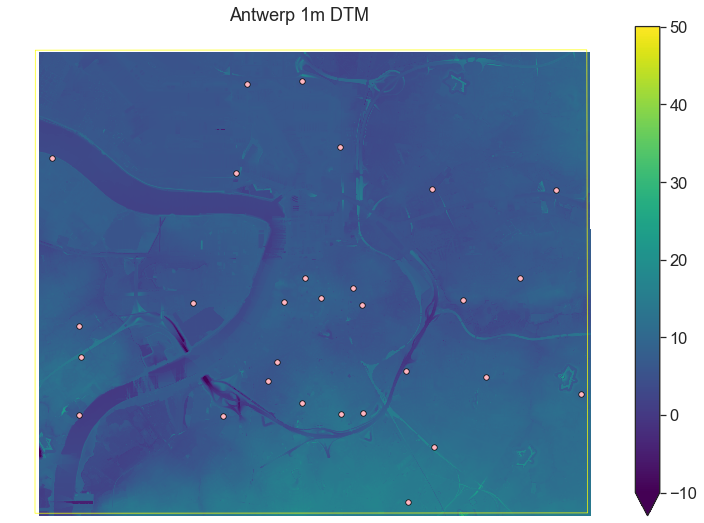

In [44]:
# Plot the data 
f, ax = plt.subplots(figsize=(16, 9))

im = dtm.plot.imshow(ax=ax, add_colorbar=True, cmap='viridis', vmin=-10, vmax=50)

gws['geometry'].plot(color='lightpink', edgecolor="black",
                     markersize=30, linewidth=0.7, ax=ax, zorder=1)

bbox['geometry'].plot(color='none', edgecolor="yellow",
                     linewidth=0.7, ax=ax, zorder=1)

ax.set_title("Antwerp 1m DTM")
ax.set_axis_off()
plt.show()

## 4. Get  Digital Surface Model (DSM)

In [45]:
# load data
path = '/Volumes/Transcend/lora/data/antwerp-gis/dsm-1m-clipped.tif'
dsm = rxr.open_rasterio(path, masked=True)  # maks NaNs
dsm = dsm.squeeze()

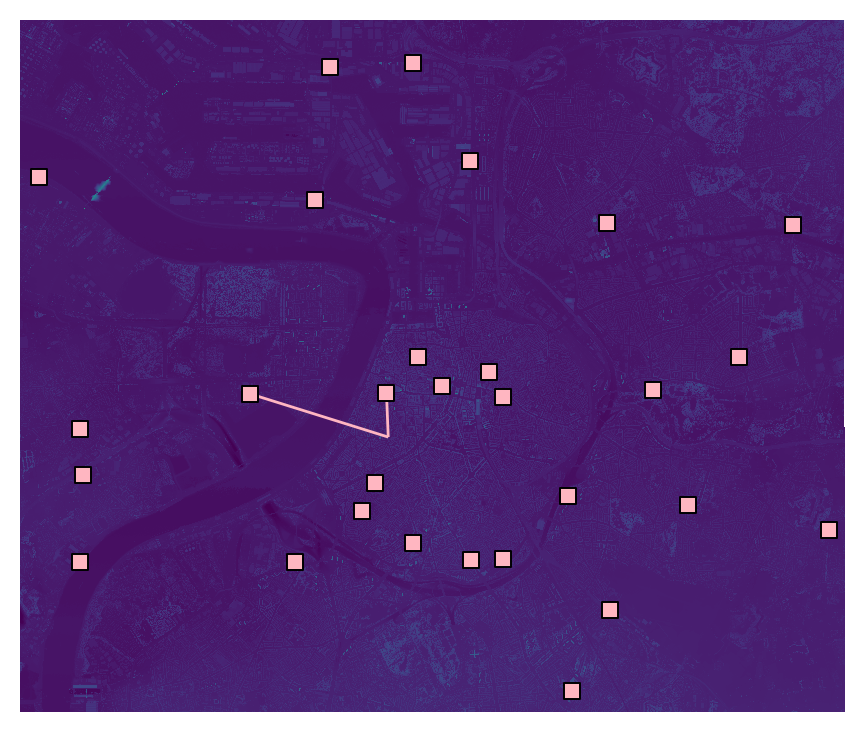

In [47]:
# Plot raster 
f, ax = plt.subplots(dpi=200)

im = dsm.plot.imshow(ax=ax, add_colorbar=False, cmap='viridis', vmin=-10, vmax=250)

# plot links
temp = gdf.query("packet_id == 39073 & rssi.notnull()")
temp.plot(ax=ax, linewidth=1, edgecolor='lightpink', alpha=1,  zorder=11)

temp2 = gdf.query("packet_id == 39073 & ~rssi.notnull()")
#temp2.plot(ax=ax, linewidth=.5, edgecolor='yellow', alpha=1,  zorder=11)

gws['geometry'].plot(color='lightpink', edgecolor="black", marker='s',
                     markersize=30, linewidth=0.7, ax=ax, zorder=12)

ax.set_title(None)
ax.set_axis_off()
plt.tight_layout()
#plt.savefig("links_success.png")
plt.show()

## 5. Extract Link Attributes from GIS data

See e.g. a point (circle) extraction [tutorial](https://www.earthdatascience.org/courses/use-data-open-source-python/spatial-data-applications/lidar-remote-sensing-uncertainty/extract-data-from-raster/)

In [48]:
import rasterstats as rs

### 5.1 Get gateway and packet-origin elevation

In [49]:
# get GWS elevation
gws_ele = gws.copy() # create a buffered polygon

# replace point with 1m radius polygon
gws_ele["geometry"] = gws.geometry.buffer(1) 

# Extract zonal stats
gw_elevation = rs.zonal_stats(gws_ele.geometry,
                              dsm.values,
                              nodata=np.nan,
                              affine=dsm.rio.transform(),
                              geojson_out=True,
                              copy_properties=True,
                              stats="count min mean max median")


# make gdf
gws_ele = gpd.GeoDataFrame.from_features(gw_elevation)

# set values to original df
gws['elevation'] = gws_ele['median'].values

In [50]:
# get packet source elevation
packets = gdf.groupby('packet_id').first()

geometry = [Point(xy) for xy in zip(packets['lon_tr'], packets['lat_tr'])]

# makge geopandas df
packets = gpd.GeoDataFrame(packets, geometry=geometry)

packets = packets.set_crs('epsg:4326')
packets = packets.to_crs("EPSG:31370")

In [51]:
# replace point with 1m radius polygon
packets['geometry'] = packets.geometry.buffer(1) 

# Extract zonal stats
packet_ele = rs.zonal_stats(packets.geometry,
                            dsm.values,
                            nodata=np.nan,
                            affine=dsm.rio.transform(),
                            geojson_out=True,
                            copy_properties=True,
                            stats="count min mean max median")


# make gdf
pck_ele = gpd.GeoDataFrame.from_features(packet_ele)

# set values to grouped df
packets['elevation'] = pck_ele['median'].values

# update main gdf with elevation data
gdf['ele_tr'] = gdf['packet_id'].map(dict(packets['elevation']))
gdf['ele_gw'] = gdf['gateway_id'].map(dict(gws['elevation']))

In [52]:
# print summaries
mean_tr, mean_gw = packets['elevation'].mean(), gws['elevation'].mean()

print("The mean transmitter is  %.2f m above sea level." % mean_tr)
print("The mean gateway is at  %.2f m above sea level." % mean_gw)

The mean transmitter is  11.19 m above sea level.
The mean gateway is at  27.69 m above sea level.


In [53]:
# assume packets are 1.5 m off the ground surface (mounted on cars)
gdf['ele_tr'] = gdf['ele_tr'] + 1.5

In [66]:
gdf['success'] = gdf['rssi'].notnull()

In [67]:
gdf.success.mean()

0.09491159682583879

In [72]:
 1 / gdf.gateway_id.nunique()

0.034482758620689655

In [59]:
# Save file
gdf.to_file("antwerp_links.geojson")

/Users/sander/miniforge3/envs/lora/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


### 5.2 Get link trajectory in points

In [54]:
# define link query tool
def get_link(orig, dest, points):
    """
    :param orig: [lon, lat, ele] of origin
    :param dest: [lon, lat, ele] of destination
    :param points: number of points queried along path
    """
    arr = np.linspace(orig, dest, points)
    
    return(arr)

In [55]:
def raster_values(lon, lat, raster, buffer, method='median'):
    """
    get raster values for given points
    """

    # zip the coordinates into a points
    points = [Point(xy) for xy in zip(lon, lat)]

    # makge geopandas df
    gdf = gpd.GeoDataFrame(geometry=points)
    
    # set standard projection
    gdf = gdf.set_crs('epsg:4326')
    
    # reproject to match raster
    gdf = gdf.to_crs(str(raster.rio.crs))
    
    # buffer points to circles
    gdf['geometry'] = gdf['geometry'].buffer(buffer) 

    # extract raster data
    values = rs.zonal_stats(gdf['geometry'],
                            raster.values,
                            nodata=raster.rio.nodata,
                            affine=raster.rio.transform(),
                            geojson_out=True,
                            copy_properties=False,
                            stats=method)

    # make gdf
    gdf = gpd.GeoDataFrame.from_features(values)

    return gdf[method].values

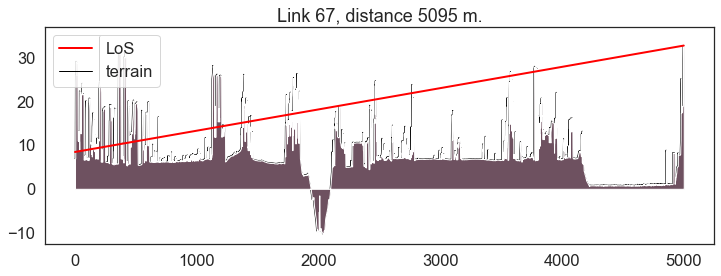

In [56]:
# show plot of what data is queried

link = 67

# get data
orig = gdf.iloc[link][['lon_tr', 'lat_tr', 'ele_tr']]
dest = gdf.iloc[link][['lon_gw', 'lat_gw', 'ele_gw']]

dist = gdf.iloc[link]['distance'] # get distance

arr = get_link(orig, dest, 5000) # arr[:,0] lon, arr[:,1] lat, arr[:,2] ele

crow = arr[:,2] # elevation on straight path

terr = raster_values(arr[:,0], arr[:,1], dsm, 1)


# make plot
f, ax = plt.subplots(figsize=(12,4))

x = np.arange(len(crow))

plt.plot(x, crow, color='red', linewidth=2, zorder=5)
plt.plot(x, terr, color='black', linewidth=1, zorder=1)

ax.fill_between(x, 0, terr, facecolor="#6E5160")

plt.legend(['LoS', 'terrain'], loc='upper left')
ax.set_title("Link %d, distance %.f m." %(link, dist))

plt.show()

### 5.3 Coosing features

A bit arbitrary though the wireless networks literature provides some standards.

Used here are:
 - **% obstructed** = proportion of points on the LoS line below the surface layer.
 - **mean difference** = sum(LoS - DSM) / (# points)
 - **median difference** = median(LoS - DSM)

In [101]:
# experiment to see how nr. points affects results

link = 67  # choose a link

# initialize experiment 
nmpts = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 75, 100, 125, 150, 175, 200]
reslt = np.zeros((len(nmpts), 3))

# get data
orig = gdf.iloc[link][['lon_tr', 'lat_tr', 'ele_tr']]
dest = gdf.iloc[link][['lon_gw', 'lat_gw', 'ele_gw']]

# run experiments
for i in range(len(nmpts)):
    # get array of nmpts[i] points
    arr = get_link(orig, dest, nmpts[i]) # arr[:,0] lon, arr[:,1] lat, arr[:,2] ele

    crow = arr[:,2] # elevation of straight path
    terr = raster_values(arr[:,0], arr[:,1], dsm, 1) # elevation of surface along path

    reslt[i][0] = np.mean(crow <= terr)
    reslt[i][1] = np.mean(crow - terr)
    reslt[i][2] = np.median(crow - terr)
    #reslt[i][3] = np.sum(crow < terr)
    
print('Experiment completed')

Experiment completed


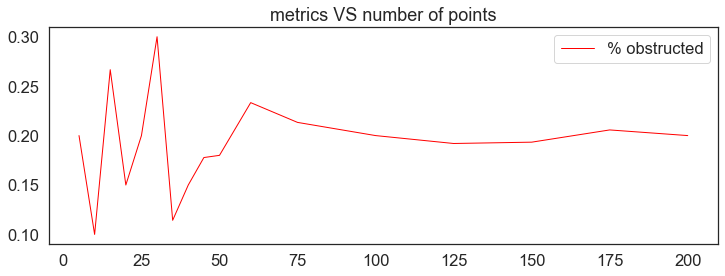

In [103]:
# plot results 
f, ax = plt.subplots(figsize=(12,4))

#x = np.arange(len(nmpts))
x = nmpts

plt.plot(x, reslt[:,0], color='red', linewidth=1, markersize=5)
#plt.plot(x, reslt[:,1], color='blue', linewidth=1)
#plt.plot(x, reslt[:,2], color='green', linewidth=1)
#plt.plot(x, reslt[:,3], color='orange', linewidth=1)

plt.legend(['% obstructed', 'mean diff', 'median diff', 'nr obstacles'], loc='upper right')
ax.set_title("metrics VS number of points")

plt.show()

### 5.4 Query the raster and expand dataset

In [98]:
gdf['packet_id'].nunique()

1384

In [100]:
# sample smaller dataframe

# get one batch of packet ids
packets = gdf['packet_id'].unique()[1300:1384]

# get all links of m packes
gdfsmall = gdf[gdf['packet_id'].isin(packets)].copy()

n = gdfsmall.shape[0]

print("Sampled %d rows from %d unique packets." % (n, len(packets)))

Sampled 1008 rows from 84 unique packets.


In [92]:
# a get link attributes from paths

# get input data of length n
orig = gdfsmall[['lon_tr', 'lat_tr', 'ele_tr']].values
dest = gdfsmall[['lon_gw', 'lat_gw', 'ele_gw']].values

points  = 100
n = gdfsmall.shape[0]

# get data array of shape: points x n x 3
arr = get_link(orig, dest, points) 

# flatten data array: (points * n) x 3 
new_arr = arr.reshape((arr.shape[0]*arr.shape[1]), arr.shape[2])

# get elevation of link sequences
crow = new_arr[:,2] # [n first eleves, n 2nd eleves, ..., n point-th eleves]

# read raster
terr = raster_values(new_arr[:,0], new_arr[:,1], dsm, 1)

print("Done reading raster.")


# post process data
print("Processing data into dataframe...")

crow = crow.reshape((points,n)).transpose()
terr = terr.reshape((points,n)).transpose()

# get mean
obs = np.mean(crow <= terr, axis=1)
dmn = np.mean(crow - terr, axis=1)
dmd = np.median(crow - terr, axis=1)

# store in df
gdfsmall['obstructed'] = obs
gdfsmall['mean_los_dif'] = dmn
gdfsmall['medn_los_dif'] = dmd

# save df to disk
print("Saving to disk...")

file = '/Volumes/Transcend/lora/data/traffic/processed-links-15.geojson'
gdfsmall.to_file(file, driver='GeoJSON')

print("Dataframe saved.")

Done reading raster.
Processing data into dataframe...
Saving to disk...
Dataframe saved.


In [ ]:
# generate a grid of points and query all distances to some given GW 

In [ ]:
def transverseMerc(lats, lons):
    '''
    See original formula at @
    https://en.wikipedia.org/wiki/Transverse_Mercator_projection#Direct_transformation_formulae
    '''
    
    longitude_offset = 4.400278 # This is for the city of choice (Antwerp)
    k_0 = 0.9996
    a = 6378137 # equatorial radius (m)
    # Note on equations : lats == phi, lons = lambda.
    
    lats = np.radians(lats)
    lons = np.radians(lons - longitude_offset)
    
    sin_lambda = np.sin(lons)
    cos_phi = np.cos(lats)
    ln_num = 1 + sin_lambda * cos_phi
    ln_den = 1 - sin_lambda * cos_phi
    ln_x = np.log(ln_num / ln_den)
    x = k_0 * a * ln_x / 2
    
    cos_lambda = np.cos(lons)
    tan_phi = np.tan(lats)
    y = k_0 * a * np.arctan(tan_phi / cos_lambda)
    
    return x, y

# compute transverse mercator coords

In [ ]:
# post process data
crow = crow.reshape((points,n)).transpose()
terr = terr.reshape((points,n)).transpose()

# get mean
obs = np.mean(crow <= terr, axis=1)
dmn = np.mean(crow - terr, axis=1)
dmd = np.median(crow - terr, axis=1)

# store in df
gdfsmall['obstructed'] = obs
gdfsmall['mean_los_dif'] = dmn
gdfsmall['medn_los_dif'] = dmd

### Moving on...

 - Can work on additional features later
 - Let's tune a GP with what we have and *produce some plots*
     - A good plot shows the rssi at GW i from a range of locations (at ground level)
     - This lets you visualize shadowing etc - should be nice an clear!

#### Contributions of 'my' GP-based method.
 - View **links as points**; other methods assume fixed gateway / access point locations
     - This lets network planners identify potential locations for new gateways
 - Do statistically sound **inference** over links w/o data (true for most GPs)
 - Incorporate **censored or missing data** in a stastistically sound manner
 - Show **connection** between propagation modeling and localization
     - One has path loss as missing data; other has transmitter location
 - Abitily to perform path loss modeling, localization, and radio mapping in one coherent model
 - Allow the use of **large volumes of data** viea nearest neighbor methods and parallelization
 
 - **Method**: Bayesian Spatial Statistics with Censored and Missing Data

### Old tools

In [ ]:
# Manual filtering of data

# set crs
#dtm.rio.set_crs('EPSG:31370')

# get raster to numpy
#array = dtm.values

# mask values 
#array[array==-9999] = np.nan

# ndarray to raster
#dtm = xr.DataArray(array, coords=dtm.coords)

#dtm = dtm.squeeze()

In [ ]:
# histogram
dsm.plot.hist()
plt.show()

In [ ]:
# declare bounding box - based on ever used GWs in Antwerp
w = 4.16
e = 4.62
s = 51.13
n = 51.33
bbox = [w, s, e, n]

p1 = Point(bbox[0], bbox[3])
p2 = Point(bbox[2], bbox[3])
p3 = Point(bbox[2], bbox[1])
p4 = Point(bbox[0], bbox[1])

np1 = (p1.coords.xy[0][0], p1.coords.xy[1][0])
np2 = (p2.coords.xy[0][0], p2.coords.xy[1][0])
np3 = (p3.coords.xy[0][0], p3.coords.xy[1][0])
np4 = (p4.coords.xy[0][0], p4.coords.xy[1][0])

bb_polygon = Polygon([np1, np2, np3, np4])

bbox = gpd.GeoDataFrame(gpd.GeoSeries(bb_polygon), columns=['geometry'])

In [ ]:
# set bbox crs to raster crs
crs = raster.rio.crs
bbox = bbox.set_crs(crs)
print(bbox.crs)

In [ ]:
# Calculate canopy height model
chm = dsm - dtm

# Plot raster 
f, ax = plt.subplots(figsize=(16, 9))

im = chm.plot.imshow(ax=ax, add_colorbar=True, cmap='viridis', vmin=-10, vmax=50)

# plot links
temp = gdf[gdf['rssi'].notnull()]
temp.plot(ax=ax, linewidth=0.2, edgecolor='pink', alpha=0.1,  zorder=11)

# plot GWs
gws['geometry'].plot(color='lightpink', edgecolor="black",
                     markersize=20, linewidth=0.7, ax=ax, zorder=12)

ax.set_title("Antwerp 1m CHM")
ax.set_axis_off()
plt.show()